# ASP3231 Laboratory 4: Calibrated Catalogues

In this week's laboratory we going to use archival data to estimate V-band magnitudes of bright stars, create a catalogue of celestial objects using Monash C14 data and use that catalogue to produce a histogram of astronomical magnitudes.

## Prelab Questions

You are expected to read the lab notebook prior to the lab, and the Prelab Questions are designed to prompt you to consider what you have read. This will hopefully prepare you for the lab session and ultimately save time.

#### Question 1: Why do the magnitudes of stars depend on the filter they are measured in?

#### Question 2: If a star has a colour of B-V=0 why does it typically have roughly U-B=0 and V-R=0 too (for Vega-basd magnitudes)?

#### Question 3: Open AladinLite (https://aladin.u-strasbg.fr/AladinLite/), find NGC 4755 (Jewel Box) and use the SIMBAD catalogue to determine the name and V-band magnitude of a star. (Note SIMBAD magnitudes are archival and of varying quality, sometimes using CCD photometry but on occassion using photographic plate photometry).

#### Question 4: Plot a parabola in using matplotlib.

#### Question 5: Produce a histogram using matplotlib for a list that you've written yourself. Have at least ten numbers in your list. 


>1. Some stars simply emit more photons in one wavelength region compared to another - this is often reflective of the colour of the star, which is a result of Planck's law relating the temperature of a blackbody-like object to its spectral properties.

>2. These wavelengths are clustered close enough together for the approximate difference in magnitudes to about the same.

>3. Selecting NGC 4755 308, I get a V band magnitude of 13.477



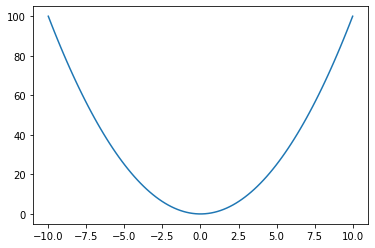

In [88]:
# question 4
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)
y = x**2

fig, ax = plt.subplots()
ax.plot(x, y)


[]

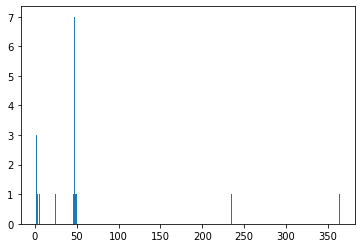

In [89]:
# Question 5
mylist = [1, 2, 5, 1, 365, 1, 2, 234, 235, 24, 3,
          149, 45, 46, 47, 47, 47, 47, 47, 47, 47, 48, 49]
fig = plt.hist(mylist, bins=(max(mylist)-min(mylist)))
plt.plot()


**Task 1.** As always we import various libraries. A new one this week is astroquery - what does it do?

In [90]:
# Import various libraries

import numpy as np
import astropy
import photutils
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import astropy.io.fits as fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from photutils import DAOStarFinder
from photutils import detect_sources, deblend_sources, source_properties
from scipy.ndimage import shift
import gc

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Astroquery provides a wrapper for formatted API calls to various public databases of astronomical data.
# It'll allow us to have our code communicate directly with the remote database, instead of having to do the manual step of finding the data by typing it in ourselves.


/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_10398/3556658392.py:14: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_10398/3556658392.py:14: DeprecationWarning: `photutils.centroid_1dg` is a deprecated alias for `photutils.centroids.centroid_1dg`. Instead, please use `from photutils.centroids import centroid_1dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_10398/3556658392.py:14: DeprecationWarning: `photutils.centroid_2dg` is a deprecated alias for `photutils.centroids.centroid_2dg`. Instead, please use `from photutils.centroids import centroid_2dg` to silence this warning.
  from photutils import 

**Task 2.** Rather than having many lists (arrays) of numbers to describe data, it can be useful to have a class that bundles things together. For example, the following class includes details for standard stars (stars of well known magnitude) and/or observations of such stars. 

In [91]:
# Here's the star class, which includes a name, coordinates, exposure time, airmass, UBVRI fluxes, UBVRI magnitudes.

class Star:
    def __init__(self):
        self.name = "Default name"                                # Object name
        self.filename = "NULL                                  "  # Image file name
        # J2000 coords ra+dec (initially given dummy values)
        self.ra = -99.0
        self.dec = -99.0
        # CCD pixel coords x-y (intially given dummy values)
        self.x = -99.0
        self.y = -99.0
        # UBVRI Fluxes (intially given dummy values)
        self.flux = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # UBRRI Magnitudes (intially given dummy values)
        self.mag = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # G_BP, G and G_RP Magnitudes (intially given dummy values)
        self.gaiamag = [-99.0, -99.0, -99.0]
        self.exptime = 1.0
        self.airmass = 1.0


>Note that the required data structures are stored as instance variables of the class - these are initialised with the given default values every time an object of the class is createed. They can be accessed by 'object'.'instance_var'

In [92]:
# for example
test_star = Star()
test_star.exptime


1.0

**Task 3.** For the ASP3231 projects we are using UBVRI filters that are similar to those used by Graham (1982). Graham (1982) precisely measured UBVRI magnitudes for a series of stars in the south, and we have often used these to calibrate ASP3231 project data. The function below is designed to read the Graham (1982) text file - read the comments about that this function does.

In [93]:
# This reads in the photometry from the Graham (1982) standard star photometry and converts to decimal degrees

def readgraham(fname):

  # Set the list of standards to a blank list.
    gstandards = []

    # Open the text file defined by fname, then import the ASCII lines from the file into grahamtext
    with open(fname) as f:
        grahamtext = f.readlines()

    # Step through each line of grahamtext. The current line is thisline and it has index imx
    for imx, thisline in enumerate(grahamtext):

        # Read in coordinates - each variable has specific columns, defined in the README file
        # Read in RA hours from the ASCII, and covert to float
        rah = float(thisline[15:17])
        # Read in RA minutes from the ASCII, and covert to float
        ram = float(thisline[18:20])
        # Read in RA seconds from the ASCII, and covert to float
        ras = float(thisline[21:25])
        # Read in Dec degreess from the ASCII, and convert to float
        decd = float(thisline[27:29])
        # Read in Dec arcminutes from the ASCII, and convert to float
        decm = float(thisline[30:32])
        # Read in Dec arcseconds from the ASCII, and convert to float
        decs = float(thisline[33:35])

        # Convert the coordinates to decimal degrees.
        ra = 15.0*(rah+ram/60.0+ras/3600.0)   # Convert RA to decimal degrees
        dec = decd+decm/60.0+decs/3600.0      # Convert Declination to decimal degrees
        if thisline[26] == '-':               # If the declination is negative, convert accordingly
            dec = 0-dec

        # Read in the photometry
        # Temporary UBVRI magnitude list - initially unphysical values
        tmag = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # Read V magnitude from thisline and convert to float
        tmag[2] = float(thisline[36:41])
        # Read in B-V colour from thisline, convert to float, produce B magnitude.
        tmag[1] = float(thisline[50:56])+tmag[2]
        if (thisline[47] != ' '):
            # Read in U-B colour from thisline (if available), convert to float, produce U magnitude
            tmag[0] = float(thisline[50:56])+tmag[1]
        # Read in V-R colour from thisline, convert to float, prodcue R magnitude
        tmag[3] = tmag[2]-float(thisline[57:62])
        if (thisline[68] != ' '):
            # Read in R-I colour from thisline, convert to float, produce I magnitude
            tmag[4] = tmag[3]-float(thisline[64:69])

        # Create temporary tstandard, which has class star, and populate it with data from Graham (1982)
        tstandard = Star()                            # Create tstandard with class star
        # Get the name from thisline
        tstandard.name = thisline[0:12]
        tstandard.ra = ra                             # Get the RA
        tstandard.dec = dec                           # Get the Declination
        tstandard.mag = tmag                          # Get the UBVRI magnitudes

        # Extend the list gstandards with tstandard
        gstandards.extend([tstandard])

    # The end of the indentation is where there's the end of the for-loop

    # The end of the function, which returns the list of Graham Standards names, coordinates and UBVRI magnitudes
    return gstandards


> This is a funciton that takes a file name and returns a list of standards based on that file. A rough overview of its workings: it reads the file to an array called grahamtext, then iterates through the lines and stores the standardised format based on string indexing to RA and declination data.

> Then, the RA and declination are mathematically converted to degrees, more information is read from the line, and a Star object is created and the instance variables are assigned to the correct values. These Star objects are then shoved into an array and returned.

**Task 4.** To actually run the function above you must run the cell below.

In [94]:
gstandards = readgraham('Graham1982.txt')
print(len(gstandards))
print(gstandards[0].ra, gstandards[0].dec, gstandards[0].mag)


102
21.174583333333334 -44.52833333333333 [8.562, 7.4159999999999995, 6.27, 5.699999999999999, 5.1899999999999995]


>Here, we've read the data from the specified text file, then printed the RA, declination and magnitude of the first star.

To use the Graham (1982) standards effectively we need perfectly clear nights, which are rare in Melbourne. Another option is to leverage off all sky photometry, such as the GAIA mission. The catch is GAIA uses G_BP, G and G_RP filters not the standard U, B, V, R and I filters, so we to establish the releationships between Graham (1982) photometry and Gaia photometry.

**Task 5.** The function below queries the GAIA database for photometry of Graham standards.

In [95]:
def getgaia(gstandards):
    for obj in gstandards:
        coord = SkyCoord(ra=obj.ra, dec=obj.dec, unit=(
            u.degree, u.degree), frame='icrs')
        radius = u.Quantity(0.001, u.deg)
        j = Gaia.cone_search_async(coord, radius)
        r = j.get_results()
        if len(r) > 0:
            obj.gaiamag[0] = r[0]['phot_bp_mean_mag']
            obj.gaiamag[1] = r[0]['phot_g_mean_mag']
            obj.gaiamag[2] = r[0]['phot_rp_mean_mag']
    return gstandards


>Here, we use Gaia object to get the Gaia data based on the position in the sky of the object. We're deserialising between the API data format and a data format useful to us with a for loop. 

**Task 6.** If we ran all the code below, we would query the Gaia database (which would actually take a little while) and write the results to a csv format file. Instead we are going to skip this and read the results straight from a csv file that was prepared earlier.

In [96]:
i = 0  # If i=1 then query the GAIA database
if i == 1:
    gstandards = getgaia(gstandards)
    f = open("graham_gaia.csv", "w")
    f.write("Name, RA_J2000,DEC_J2000,U,B,V,R,I,G_BP,G,G_RP\n")
    for obj in gstandards:
        f.write("%s , " % obj.name)
        f.write("%9.5f , " % obj.ra)
        f.write("%9.5f , " % obj.dec)
        f.write("%6.3f , " % obj.mag[0])
        f.write("%6.3f , " % obj.mag[1])
        f.write("%6.3f , " % obj.mag[2])
        f.write("%6.3f , " % obj.mag[3])
        f.write("%6.3f , " % obj.mag[4])
        f.write("%6.3f , " % obj.gaiamag[0])
        f.write("%6.3f , " % obj.gaiamag[1])
        f.write("%6.3f \n" % obj.gaiamag[2])
    f.close()


**Task 7.** Lets load in the Graham and GAIA photometry from the existing csv file

In [97]:
grgaia = []
f = open("graham_gaia.csv", "r")
grahamtext = f.readlines()
for line in grahamtext:
    currentline = line.split(",")
    if currentline[0] != "Name":
        tstandard = Star()
        tstandard.name = currentline[0]
        tstandard.ra = float(currentline[1])
        tstandard.dec = float(currentline[2])
        tstandard.mag[0] = float(currentline[3])
        tstandard.mag[1] = float(currentline[4])
        tstandard.mag[2] = float(currentline[5])
        tstandard.mag[3] = float(currentline[6])
        tstandard.mag[4] = float(currentline[7])
        tstandard.gaiamag[0] = float(currentline[8])
        tstandard.gaiamag[1] = float(currentline[9])
        tstandard.gaiamag[2] = float(currentline[10])
        grgaia.extend([tstandard])
f.close()


**Task 8.** Lets now plot V minus G as a function of GAIA G_BP minus G, and fit that data. Add comments to explain what the code is doing. Describe in words what the plot is.

[0.48446054 0.22184931 0.00858087]


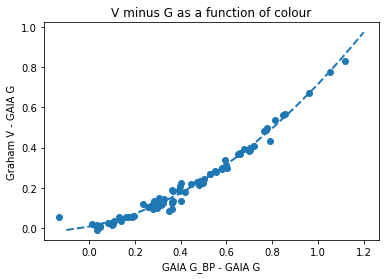

In [98]:
# Plot the difference between V and G as a function of GAIA G_BP and G.

# What is px and py? What is the if statement doing?
px = []
py = []

# here, we initialise empty lists to store our x, y parameter data for each star. Reading a single star's x and y coordinate in the parameter space will add one entry to px and one entry to py - but
# note that this data is order sensitive

for obj in grgaia:
    # Check if we have valid Graham and GAIA magnitudes and colours for the star in question.
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        px.append(obj.gaiamag[0]-obj.gaiamag[1])      # G_BP minus G
        py.append(obj.mag[2]-obj.gaiamag[1])          # V minus G

    # Here, we're checking for magnitude data in the if statements. The first ensures that the V band magnitude is between 0 and 20
    # The second ensures that the bp filter magnitude is between 0 and 20
    # The third ensures that the mean magnitude in the g band is between 0 and 20.


# What is this doing?
# Here, we're using np.polyfit to find a polynomial fit of the x and y data. The third argument is 2 to ensure that we fit a degree 2 polynomial (a quadratic).

Vpoly = np.polyfit(px, py, 2)
# Vpoly is a polynomial fit for the V-band
print(Vpoly)

# The format of this is that the equation of the fit is y = Vpoly[0] x^2 + Vpoly[1] x + Vpoly[2]

# What are plx and ply?
# plx is an np array with evenly spaced values between -0.1 and 1.3, with distance in between values of 0.1.as_integer_ratio
# ply is an empty array at first, but we then populate it with the sampled values of the polynomial fit.

# Conceptually, we're creating a pair of x and y arrays corresponding to sampled points on the polynomial fit curve, so that we have points to plot.
plx = np.arange(-0.1, 1.3, 0.1).tolist()
ply = []
for x in plx:
    ply.append(Vpoly[2]+Vpoly[1]*x+Vpoly[0]*x*x)

# What are these lines doing?
plt.title('V minus G as a function of colour')
plt.ylabel('Graham V - GAIA G')
plt.xlabel('GAIA G_BP - GAIA G')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# Here, we create a plot. The key lines is plt.scatter, which creates a scatter graph from the data, with each dot being a star's x and y value.
# The last line plots the polynomial fit line using the sample data of the points on the polynomial fit.


> Here, we've plotted on the x axis the difference in magnitude between the Gaia BP band and the Gaia G band (which corresponds to a colour) against the difference between the graham v band magnitude and the gaia g band magnitude.

>Conceptually, it allows us to see the deviation between Gaia standards and Graham standards as a function of Gaia colour.

**Task 9.** Adapt the code above to plot and fit Graham R minus GAIA G_RP as a function of GAIA G minus GAIA G_RP.

**Hint:** Don't reuse Vpoly and instead create Rpoly.

[0.40048953 0.33460064 0.01283236]


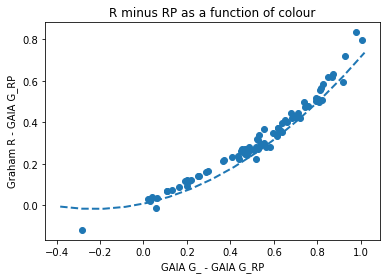

In [99]:
px = []
py = []


for obj in grgaia:
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        # G minus G_RP. Here, we've selected the different indices corresponding to the correct filter.
        px.append(obj.gaiamag[1]-obj.gaiamag[2])
        py.append(obj.mag[3]-obj.gaiamag[2])          # Graham R minus G_RP


Rpoly = np.polyfit(px, py, 2)
print(Rpoly)


# Here, I've queried the minimum and maximum values of px in order to produce the domain of our polynomial plot
plx = np.arange(min(px) - 0.1, max(px) + 0.1, 0.1).tolist()
ply = []
for x in plx:
    ply.append(Vpoly[2]+Vpoly[1]*x+Vpoly[0]*x*x)

plt.title('R minus RP as a function of colour')
plt.ylabel('Graham R - GAIA G_RP')
plt.xlabel('GAIA G_ - GAIA G_RP')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# The bulk of this code is adapted from the cell above, but with care taken to ensure that the indices selected are correct.


**Task 10.** A bright star in Jewel Box (HD 111990) is located at RA=193.49911961463 DEC=-60.33542302933, and has G_BP=6.85, G=6.69 and G_RP=6.43. Run the following GAIA query to confirm the photometry.

In [100]:
gmag = [-99.0, -99.0, -99.0]
# initialise g magnitudes to values unreasonably bright - as a placeholder
coord = SkyCoord(ra=193.49911961463, dec=-60.33542302933,
                 unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.001, u.deg)
j = Gaia.cone_search_async(coord, radius)
# make the api call
r = j.get_results()
if len(r) > 0:
    gmag[0] = r[0]['phot_bp_mean_mag']
    gmag[1] = r[0]['phot_g_mean_mag']
    gmag[2] = r[0]['phot_rp_mean_mag']
    print(gmag)


INFO: Query finished. [astroquery.utils.tap.core]
[6.847493, 6.68693, 6.4292483]


> Here, we're searching for the Gaia data for that region. Note we use cone_search_async in order to search for that region of the sky as a cone in the celestial sphere.

**Task 11.** Determine the V and R band magnitudes for this star. To do this use your previous results for V - G as a function of G_BP - G, and R - G_RP as a function of G - G_RP. (If the GAIA query did not run then use the values stated in the notebook.)

In [101]:
# Let's use the polynomial fit in order to compute the magnitudes in these bands.

bp_minus_g = gmag[0] - gmag[1]
v_minus_g = Vpoly[0]*bp_minus_g**2 + Vpoly[1]*bp_minus_g + Vpoly[2]
v_mag_hd111990 = v_minus_g + gmag[1]
print(v_mag_hd111990)


g_minus_rp = gmag[1] - gmag[2]
r_minus_rp = Rpoly[0]*g_minus_rp**2 + Rpoly[1]*g_minus_rp + Rpoly[2]
r_mag_hd111990 = r_minus_rp + gmag[2]
print(r_mag_hd111990)

# Here, I'm just calculating the y value for the polynomial for each x value, then performing the subtracting in order to get back the raw V and R band data.

6.743621465182257
6.554893684659008


**Task 12.** We are now going to generate a catalogue of objects for the Jewel Box Cluster. As the stars in our Jewel Box image are reasonably well seperated, we will use the segmentation (rather than model fit approach). Run the following code and comment on what each line is doing and what the plot shows (add axis labels and a caption).

Today's image, new-image.fits, is a copy of an image taken with the C14 telescope with a world coordinate system added using astrometry.net. 

In [102]:
scim = CCDData.read("new-image.fits", unit="adu")
# This line finds the median of the counts from the image
med = np.median(scim.data)
# Here, we subtract the median to yield an array of values of deviation from the median
scim.data = scim.data-med
# Here, we compute the statistics for the image
# Note that we use sigma_clipped_stats in order to perform up to five iterations of clipping pixel values that exceed more than three standard deviations from the mean.
mean, median, std = astropy.stats.sigma_clipped_stats(
    scim.data, sigma=3.0, maxiters=5)
print('Image stats (mean, median and standard deviation):', mean, median, std)

# Here, detect_sources uses a phot_utils in order to detect sources in the image.
# The threshold is set to double the standard deviation, and we require here at least 9 connected pixels greater than double the standard deviation in order for 
# an object to be detected
# Connectivity set to 4 means that we only consider pixels as being connected if they touch along an edge, instead of just touching at a vertex.
segimage = detect_sources(scim.data, 2.00*std, 9, connectivity=4, mask=None)


Image stats (mean, median and standard deviation): 0.14082883 -0.19646645 29.830456


**Task 13.** Comment on what is being plotted here, and how it compares to the ds9 image of Jewel Box?

Text(0.5, 1.0, 'Jewel Box cluster, processed with a contiguous pixel threshold algorithm')

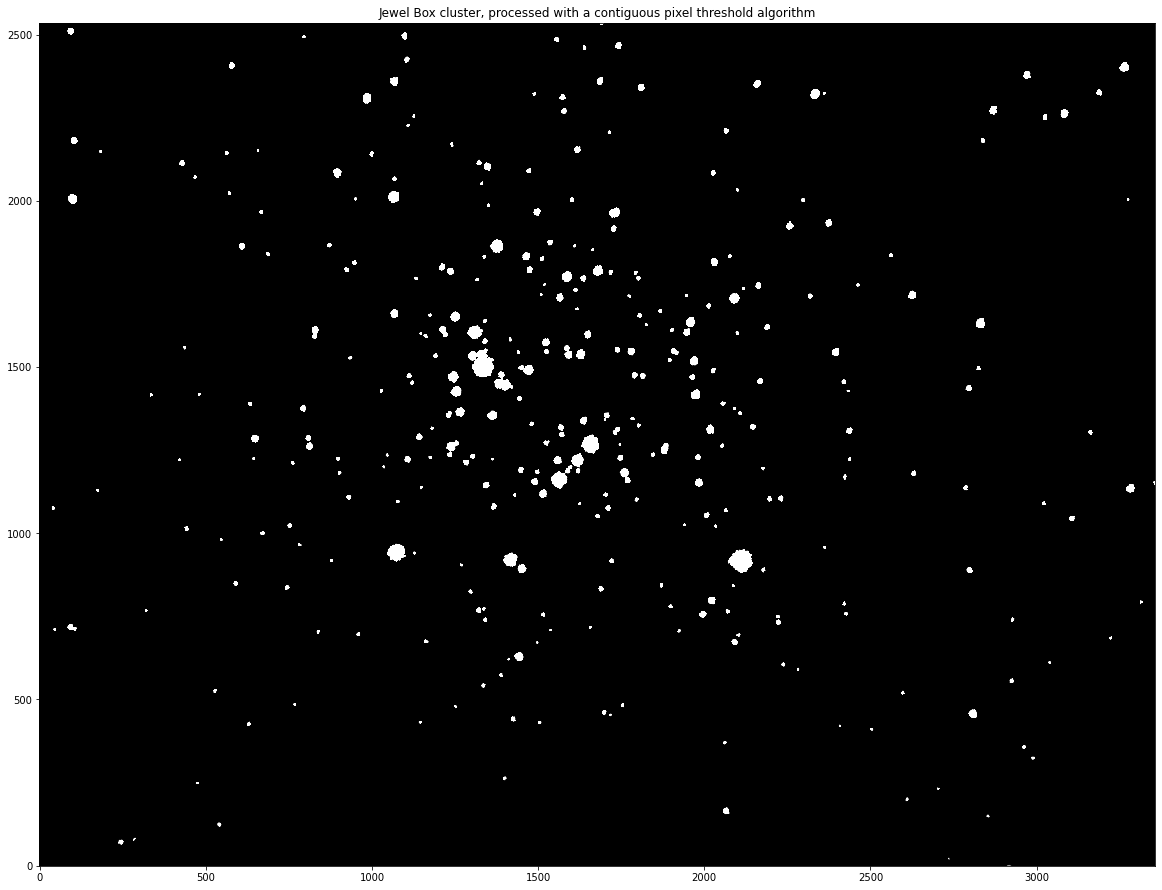

In [121]:
plt.figure(figsize=(20, 20))
plt.imshow(segimage.data, cmap='gray', vmin=0, vmax=1, origin='lower')
plt.title("Jewel Box cluster, processed with a contiguous pixel threshold algorithm")



<font color=blue> Figure 1: The Jewel Box cluster with a contiguous pixel threshold algorithm applied. Note the absence of noise from pixels that have not reached the threshold, but also note the abrupt edges of the brighter objects. 

> Here, we've plotted the Jewel Box cluster with the detection algorithm fitted. It is much more black and white, and stars have jagged edges, because the algorithm used only considers a pixel as either absolutely in, or absolutely out (above or below the threshold), and only in groups.

> It's filtered out a lot of the noise compared to the ds9 image, but some of the brighter stars are unnaturally 'abrupt' in their edges, due to the discarding of pixels at the edges.

**Task 14.** The following code writes the segmentation image to an output FITS file. Compare the segmentation image with the original image using ds9, and discuss what you see (i.e. how the images differ, and the pixel values for the segmentation map).

In [104]:
outfile = "segimage.fits"                # Set the output file name
hdu = fits.PrimaryHDU(segimage)          # Define a FITS header for this data
# Write the output, and clobber (overwrite) existing files if needed.
hdu.writeto(outfile, clobber="True")


>Well ds9 has shed light on why the edges are so abrupt - within the body of a star in the segmentation image, all the pixel values are the same! There's some sort of 'smoothing' or 'averaging' algorithm being applied here that equalises the pixel counts across all the 'active' pixels within each selected object's regions. As such, the nuances of the difference in pixel counts towards the centre or edges of the object are lost.

>In return though, we have an 'average' or mean brightness across the whole object, which allows for easier analysis with definitive 'in-or-out' pixels.

>Qualitatively, for some reason, the stars in the bottom half of the segmentation image are overall fainter than the stars in the top half of the image - when set to a linear min-max scale. I'm not sure why this is the case - the gradient seems systemic and looks far too 'smooth' to be the effect of differences in individual stars. In any case, that effect is preserved in the original image with an inspection of the pixel values in each, so it's not a result of our processing.
>
>
>
>EDIT: I'm coming back later (and in the spirit of a logbook, I won't delete the previous notes) - I've realised that the values in the segimage array correspond to indices assigned, rather than pixel counts! This explains the systemic gradient - because of course it's there when the stars are being assigned ascending indices starting at the bottom half of the image.

>That doesn't change the meaning of the plot above - but it means that I obviously cannot perform any aperture photometry on segimage.

>That's also why we only care about whether the segimage value for a particular pixel is 0 or nonzero - because it acts as a second array that *tells us whether pixels in the original array should be counted or not*. As such, it's crucial that detect_sources assigns indices beginning at 1.

**Task 15.** Let's now convert the segmentation map into a catalogue of object positions using the following code.


In [124]:
source_table = source_properties(scim.data, segimage, error=None,
                                 mask=None, background=None, filter_kernel=None, wcs=None, labels=None)
print('Source table length:\n', len(source_table))
print('First entry centroid y and x values :')  # The dreaded y-x
print(source_table[0].centroid[0].value, source_table[0].centroid[1].value)
# Caclulates the centroid of each object, then writes the values to an array.


Source table length:
 354
First entry centroid y and x values :
0.4681426312742773 2918.3464606253883


        Use `~photutils.segmentation.SourceCatalog` instead. [warnings]


> Here, we've printed the x and y coordinates of the first detected star in the array. I see it on the edge of the ds9 image, and the pixel values match up!

>If we wanted to be fancy here, we can iterate over the pixels in the image and generate a new image where we only decide to use the pixels that are nonzero in the segmentation map in the aperture sum! I'll compute these and compare my results to see if I get something more accurate.

In [ ]:
segmapped_scim_data = scim.data.copy()


for idx, row in enumerate(scim.data):
    for idy, colvalue in enumerate(row):
        if segimage.data[idx, idy] == 0:
            # note here that we're operating on medians
            segmapped_scim_data[idx, idy] = 0



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Task 16** The following code switches the source table list of centroids (in annoying y-x format) into am x-y format list of objects positions. Adapt code from previous weeks to now run 20 pixel radius aperture photometry on this x-y list of object positions.


In [137]:
positions = []
for obj in source_table:
    positions.append((obj.centroid[1].value, obj.centroid[0].value))
print(positions[0:10])  # Print example values from the positions list.


apertures = CircularAperture(positions, r=20.0)
phot_table = aperture_photometry(scim.data, apertures)
print(phot_table)



[(2918.3464606253883, 0.4681426312742773), (2737.1828269068637, 21.63361082196824), (246.40736849666035, 71.99322008991862), (286.2811294559992, 80.1064472419734), (542.0951523040715, 124.23264900150268), (2855.0462008288428, 149.8879751632971), (2066.210534730938, 165.28452012018164), (2611.7056894213397, 200.16249017094128), (2704.768945607123, 232.16425000985623), (476.2260860495117, 248.99035350809393)]
 id      xcenter            ycenter           aperture_sum   
           pix                pix                            
--- ------------------ ------------------ -------------------
  1 2918.3464606253883 0.4681426312742773  1925.6740112356997
  2 2737.1828269068637  21.63361082196824  -913.0913156859153
  3 246.40736849666035  71.99322008991862   37084.65858977432
  4  286.2811294559992   80.1064472419734  2988.5334301289768
  5  542.0951523040715 124.23264900150268    8783.04703974727
  6 2855.0462008288428  149.8879751632971  2934.7669716832906
  7  2066.210534730938 165.2845

>These values seem right - I counted up the counts for the first star at the edge of the image, and they did indeed sum to 20.

In [139]:
phot_table_segmap_filtered = aperture_photometry(segmapped_scim_data, apertures)
print(phot_table_segmap_filtered)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 2918.3464606253883 0.4681426312742773  2092.329090118408
  2 2737.1828269068637  21.63361082196824  788.6078910827637
  3 246.40736849666035  71.99322008991862 28969.142345428467
  4  286.2811294559992   80.1064472419734 2015.3741264343262
  5  542.0951523040715 124.23264900150268   8872.53837966919
  6 2855.0462008288428  149.8879751632971 2061.5112075805664
  7  2066.210534730938 165.28452012018164 61412.833015441895
  8 2611.7056894213397 200.16249017094128  3404.885139465332
  9  2704.768945607123 232.16425000985623  1110.980125427246
 10  476.2260860495117 248.99035350809393  800.6734580993652
...                ...                ...                ...
345   3264.50259078638 2402.0800315623524 114472.49980545044
346  579.4443926141706 2406.7813407595886 18389.831619262695
347  1106.402020526251 2

> Here I've performed the same calculation for the segmentation map processed array - I don't have the negative values anymore! But I'm not sure which is more 'correct' - I'll have to compute the magnitudes below and compare to known values.

**Task 17.** What flux (counts) have you measured for the bright star HD 111990 in Jewel Box that is located at RA=193.49911961463 DEC=-60.33542302933? Use https://aladin.u-strasbg.fr/AladinLite/ and ds9 to identify this star and determine its x-y coordinates, and then determine its counts in phot_table. (Remember SIMBAD magnitudes are archival and of varying quality, sometimes using CCD photometry but on occassion using photographic plate photometry).

ds9 usually displays coordinates in h\:m\:s and d\:m\:s format, but this can be changed to decimal degrees using the WCS menu.

>I've identified the coordinates as approximately x=1076, y=944 with ds9 - but I can use the code below to get an exact value considered by the table.

In [127]:
# Clue - here's a way to query a range of positions in a photometry table
# Clue - if you have a list of photometry tables, you may need to do a for loop over phot_table[0]

# for obj in phot_table:
#     if obj['xcenter'].value > 1050 and obj['xcenter'].value < 1090 and obj['ycenter'].value < 980 and obj['ycenter'].value > 920:
#         print(obj['xcenter'].value, obj['ycenter'].value, obj['id'])

# I take my approximate x and y coordinates and set some approximate bounds, within which I can accept a match.
approx_x_bounds = (1050, 1090)
approx_y_bounds = (920, 980)

# Here, I construct a generator of elems that have coords within the range, and return the first one.
hd_111990_table_id = next(obj['id'] for obj in phot_table if  approx_x_bounds[0] <= obj['xcenter'].value <= approx_x_bounds[1] 
                                                          and approx_y_bounds[0] <= obj['ycenter'].value <= approx_y_bounds[1])

# I use the same generator syntax in order to get the row in the table that matches on the conditions specified.
hd_111990_phot_row = next(elem for elem in phot_table if elem['id'] == hd_111990_table_id)
print(hd_111990_phot_row)


 id      xcenter            ycenter         aperture_sum  
           pix                pix                         
--- ------------------ ----------------- -----------------
 82 1074.1073553380193 943.1149925761813 4502823.382675131


In [140]:
hd_111990_phot_row_seg = next(elem for elem in phot_table_segmap_filtered if elem['id'] == hd_111990_table_id)
print(hd_111990_phot_row_seg)

 id      xcenter            ycenter         aperture_sum  
           pix                pix                         
--- ------------------ ----------------- -----------------
 82 1074.1073553380193 943.1149925761813 4502294.172938865


>The values match almost exactly!

**Task 18.** Determine the V-band magnitude of the fainter star near x=1444 y=629 using the flux of this star in ADU (from phot_table) and the estimated V-band magnitude and flux in ADU of HD 111990. This is simply using:
\begin{equation}
m_1 - m_2 = -2.5{\rm log_{10}} \left(\frac{f_1}{f_2} \right)
\end{equation}

Take care to use np.log10 and not np.log (which is natural log).

In [128]:
#Same procedure as above
approx_x_bounds = (1430, 1460)
approx_y_bounds = (610, 640)
star_table_id = next(obj['id'] for obj in phot_table if  approx_x_bounds[0] <= obj['xcenter'].value <= approx_x_bounds[1] 
                                                          and approx_y_bounds[0] <= obj['ycenter'].value <= approx_y_bounds[1])
star_phot_row = next(elem for elem in phot_table if elem['id'] == star_table_id)
print(star_phot_row)

# recall our result from question 10
print(v_mag_hd111990)

hd_111990_ap_sum = hd_111990_phot_row['aperture_sum']
star_ap_sum = star_phot_row['aperture_sum']

print(hd_111990_ap_sum, star_ap_sum)


# setting HD 111990 as m_2
vmag_star = -2.5*np.log10(star_ap_sum/hd_111990_ap_sum) + v_mag_hd111990 

print("Vband mag", vmag_star)

 id      xcenter           ycenter         aperture_sum  
           pix               pix                         
--- ----------------- ----------------- -----------------
 35 1444.131331676691 629.3197205118938 234588.2362206658
6.743621465182257
4502823.382675131 234588.2362206658
Vband mag 9.951568171908477


In [142]:
# Let's now check our value for our segmap referenced science image:

hd_111990_ap_sum_seg = hd_111990_phot_row_seg['aperture_sum']
star_phot_row_seg = next(elem for elem in phot_table_segmap_filtered if elem['id'] == star_table_id)
star_ap_sum_seg = star_phot_row_seg['aperture_sum']

vmag_star_seg = -2.5*np.log10(star_ap_sum_seg/hd_111990_ap_sum_seg) + v_mag_hd111990

print("Vband mag seg", vmag_star_seg)

Vband mag seg 10.003575522780174


**Task 19.** Is there a way you could check your V-band magnitude above is in the right ballpark? Can you compare to other stars or use an online database? 

> Let's check the star in ds9 to get the following coords:
> ra: 12:53:47.0351, dec: -60:18:35.529

> Checking this on simbad, I get the following:
> Star name: CPD-59 4550
> V_mag: 10.29

> This is pretty close to our computed value!


> Our segmap selective aperture sums are a bit closer to the real value (for our sample size of 1), but it's not a very big impact (and probably won't be for a bright star). But that makes sense - we've already processed for systemic abberations with the steps from the previous labs, the image pre-processing. Here we're just removing the noise, but that doesn't even necessarily mean that our resulting pixel values after applying the pixel classification algorithm are more accurate - we could just as easily cut off a bunch of meaningful pixels.

> If I had more time I could get the v band magnitudes of the stars in the image programatically, then compute the difference between the derived magnitudes for the images with and without pixel classification, and see whether there's a wholesale improvement or not. But that's just how the charts in the lecture notes are made, I presume.


**Task 20.** Produce a list (array) of V-band magnitudes for all the stars in Jewel Box.

In [164]:
def calc_vband(phot_table_row, seg = False):
    hd_111990_ap_sum_res = hd_111990_ap_sum_seg if seg else hd_111990_ap_sum
    return -2.5*np.log10(phot_table_row['aperture_sum']/hd_111990_ap_sum_res) + v_mag_hd111990 

#list comprehension to create array with func applied
maglist = [calc_vband(obj) for obj in phot_table]
print(maglist)

#brightest star 
print(min(maglist))

maglist_seg = [calc_vband(obj, True) for obj in phot_table_segmap_filtered]
#print(maglist_seg)

#list of differences in magnitudes!
print(np.array(maglist) - np.array(maglist_seg))

[15.165876823762726, nan, 11.95434803398146, 14.688688451169629, 13.518220725029607, 14.708399689815984, 11.278913193108181, 14.74438077542326, nan, 15.97678474486494, 13.85178526303563, 14.075341882762611, 13.772667527757797, 13.872853832840509, 14.195342835237572, 14.387346600463832, 13.304663062100406, 13.733591599144622, nan, 13.039139931514846, 10.511982008558466, 13.31141474010549, 12.82819498803821, 14.054318546938568, 13.960039504067417, 15.763193757586642, 13.80376610995227, 14.236531156348462, 13.84263887512079, 13.164028003157153, 14.707124377010189, 15.282596170354182, 13.977673610529461, 15.250340362599715, 9.951568171908477, 14.30897975291175, 12.035952132744818, 14.269918021732312, 13.735403983286655, 14.33413123601969, 13.214304516625564, 13.600564601551557, 14.047826420832232, 13.799274964900217, 14.44022584306252, 13.92641837028701, 11.83121854764899, 11.783458850890074, 13.94420574839271, 12.389303438346612, 13.576873715707379, 13.677184402909873, 11.535479138608002,

/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_10398/1151833128.py:3: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(phot_table_row['aperture_sum']/hd_111990_ap_sum_res) + v_mag_hd111990


>Note that nan appears when we're trying to take the magnitude of an object that has somehow got a negative count number. This is probably something that can arise for really faint stars, or incorrectly identified regions (ie, the object finding algorithm has designated an aperture in a region of empty space, in which the sum of the counts would naturally be less than the median value.)

>I also print the magnitude of the brightest object in the cluster, which yields a magnitude of about 5.97. This is remarkably similar to the values from online sources (SIMBAD) for HD 111904, which yields 5.77 in the V band!

**Task 21.** Produce a histogram of the magnitudes of the stars in Jewel Box using matplotlib. Ideally set the range so the bin width is 0.5 mag per bin.

Hint https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data

[]

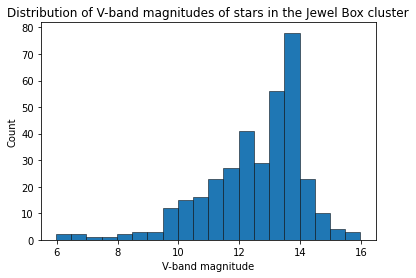

In [174]:
fig = plt.hist(np.array(maglist), bins=round((max(maglist)-min(maglist))/0.5), edgecolor='black', linewidth=0.5)
plt.xlabel("V-band magnitude")
plt.ylabel("Count")
plt.title("Distribution of V-band magnitudes of stars in the Jewel Box cluster")
plt.plot()

<font color=blue> Figure 2: Histogram of distribution of stars in the Jewel Box cluster in the V band.

# Don't forget your conclusions

> A known set of stars were used to produce a polynomial fit relating the colour of this set of stars to a particular offset for the specific instruments (telescope and filters) that we are using. This polynomial fit was applied to produce the v-band magnitude of a known bright star in a region of the sky that we are observing. The V band magnitude of HD 111990 was calculated to be 6.74 using this method.

> An object finding algorithm was applied in order to produce a segmentation image of the centroids of objects that meet a certain set of criteria with regards to their brightness (we required 9 contiguous pixels of 2 standard deviations or greater from the median). Apertures of radius 20 were then defined around these centroids, and aperture photometry was performed.

> The v-band magnitude of HD 111990 was used as a reference to calculate the V-band magnitudes of the rest of the stars in the Jewel Box cluster. The results are quite accurate - the magnitude of CPD-59 4550 was evaluated to within 0.3 of the canonical value.